In [ ]:
from pyspark.sql import SparkSession

#create session
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, dayofmonth, col, when
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import current_date
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", IntegerType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])
ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Ball_By_Ball.csv")


In [ ]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True), 
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Match.csv")

In [ ]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])
player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Player.csv")

In [ ]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(10, 2), True),  # Adjust precision and scale as necessary
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),  
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])
player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Player_match.csv")

In [ ]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])
team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Team.csv")

In [ ]:
ball_by_ball_df.show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out| lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|nonstriker_sk|fielder_match_sk|

In [ ]:

# Transformation 1: 
# Filter to include only valid deliveries (excluding extras- like white and no balls for specific analysis)
ball_by_ball_df = ball_by_ball_df.filter((col("wides")==0) & (col("noballs")==0))

# Transformation 2: 
# Aggregation: calculate the total and average runs scored in each match and innings
total_and_avg_runs = ball_by_ball_df.groupBy("match_id","innings_no").agg(
    sum("runs_scored").alias("total_runs"),
    avg("runs_scored").alias("average_runs"),
)

In [ ]:
# total_and_avg_runs.orderBy('match_id','innings_no').show(10)


In [ ]:
# Transformation 2: 
# Window function: Calculate runnung total of runs in each match for each over
windowFunction = Window.partitionBy("match_id","innings_no").orderBy("over_id")

running_total_runs = ball_by_ball_df.withColumn(
    "running_toal_runs_each_over", 
    sum("runs_scored").over(windowFunction)
)

In [ ]:

# Show running total of match number 335987
# runs_per_match_per_inns_per_over = running_total_runs.select("match_id", "over_id","innings_no","running_toal_runs_each_over").orderBy("match_id","innings_no")

# runs_per_match_per_inns_per_over.where(runs_per_match_per_inns_per_over.match_id == 335987).show(240)


In [ ]:
# Conditional column flag for high impact balls (either a wicket or more than 6 runs including extras)
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_impact",
    when( (col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == 1),True).otherwise(False)
)

# ball_by_ball_df.select("match_id", "over_id", "runs_scored", "extra_runs","bowler_wicket","high_impact").where(ball_by_ball_df.high_impact == True).orderBy("match_id", "over_id").show(300)

In [ ]:



# Check match_df: column names and its datatype 
# match_df.dtypes

# Extracting year, month and day from the 'match_date' column, for more detailed time-based analysis
match_df = match_df.withColumn("year", year("match_date"))
match_df = match_df.withColumn("month", month("match_date"))
match_df = match_df.withColumn("day", dayofmonth("match_date"))

# High margin wins: categorizing win margins into 'high', 'medium' and 'low' 501270
match_df = match_df.withColumn(
    "margin_wins_impact_category",
    when((col("win_type") == "runs") & (col("win_margin") >= 100), "high")
    .when((col("win_type") == "runs") & (col("win_margin") < 100) & (col("win_margin") >= 50), "medium")
    .when((col("win_type") == "runs") & (col("win_margin") < 50), "low")
    .when((col("win_type") == "wickets") & (col("win_margin") >= 8), "high")
    .when((col("win_type") == "wickets") & (col("win_margin") < 8) & (col("win_margin") >= 4), "medium")
    .when((col("win_type") == "wickets") & (col("win_margin") < 4), "low")
    # .when((col("win_type") == "NO Result"), "unknown")
    .otherwise("unknown")
)

# match_df.select("win_type", "win_margin", "margin_wins_impact_category").show(300)



In [ ]:
# Analyze the impact of the toss: who wins the toss and the match 

match_df = match_df.withColumn(
    "toss_match_winner",
    when((col("toss_winner") == col("match_winner")),"Yes").otherwise("No")
)
# match_df.select("toss_winner","match_winner","toss_match_winner").show()

In [ ]:


# Normalize and clean players name
player_df = player_df.withColumn("player_name", lower(regexp_replace("player_name","[^a-zA-Z0-9 ]","")))

# Handle missing values in batting hand and bowling scale
player_df = player_match_df.na.fill({"batting_hand" : "unknown", "bowling_skill" : "unknown"})

# Categorizing players based on batting hand
player_df = player_df.withColumn(
    "batting_style",
    when(col("batting_hand").contains("Left"), "Left-Handed").otherwise("Right-Handed")
) 
player_df.select("batting_hand", "player_name", "batting_style").show()

+--------------+---------------+-------------+
|  batting_hand|    player_name|batting_style|
+--------------+---------------+-------------+
|       unknown|            N/A| Right-Handed|
|Right-hand bat|       R Dravid| Right-Handed|
|Right-hand bat|       W Jaffer| Right-Handed|
|Right-hand bat|        V Kohli| Right-Handed|
|Right-hand bat|      JH Kallis| Right-Handed|
|Right-hand bat|       CL White| Right-Handed|
|Right-hand bat|     MV Boucher| Right-Handed|
|Right-hand bat|        B Akhil| Right-Handed|
|Right-hand bat|      AA Noffke| Right-Handed|
|Right-hand bat|        P Kumar| Right-Handed|
|Right-hand bat|         Z Khan| Right-Handed|
| Left-hand bat|       SB Joshi|  Left-Handed|
| Left-hand bat|     SC Ganguly|  Left-Handed|
|Right-hand bat|    BB McCullum| Right-Handed|
|Right-hand bat|     RT Ponting| Right-Handed|
|Right-hand bat|      DJ Hussey| Right-Handed|
|Right-hand bat|Mohammad Hafeez| Right-Handed|
|Right-hand bat|        WP Saha| Right-Handed|
|Right-hand b

In [ ]:
# Identify veteran players
player_match_df = player_match_df.withColumn(
    "veteran_status",
    when(col("age_as_on_match") >=35, "veteran").otherwise("non=veteran")
)

In [ ]:
# SQL
# Convert dataframe in table for sql query
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [ ]:
# Top scoring batsmen per season
top_scoring_batsmen_per_season = spark.sql("""
SELECT p.player_name, a.season, a.total
FROM (
    SELECT b.striker, b.season, SUM(b.runs_scored) AS total
    FROM ball_by_ball b
    GROUP BY b.striker, b.season
) AS a
JOIN player p ON a.striker = p.player_id
GROUP BY a.season, p.player_name, a.total 
ORDER BY a.season, a.total DESC
""")

top_scoring_batsmen_per_season.show(1000)


+--------------------+------+-----+
|         player_name|season|total|
+--------------------+------+-----+
|            SE Marsh|  2008|  614|
|           G Gambhir|  2008|  532|
|       ST Jayasuriya|  2008|  508|
|           SR Watson|  2008|  463|
|            GC Smith|  2008|  437|
|        AC Gilchrist|  2008|  431|
|           YK Pathan|  2008|  430|
|            SK Raina|  2008|  420|
|            MS Dhoni|  2008|  414|
|           RG Sharma|  2008|  399|
|            V Sehwag|  2008|  399|
|            R Dravid|  2008|  370|
|          SC Ganguly|  2008|  349|
|            S Dhawan|  2008|  340|
|       KC Sangakkara|  2008|  319|
|           DJ Hussey|  2008|  318|
|          RV Uthappa|  2008|  316|
|         SA Asnodkar|  2008|  311|
|        Yuvraj Singh|  2008|  299|
|            PA Patel|  2008|  297|
|     Y Venugopal Rao|  2008|  283|
|           JA Morkel|  2008|  235|
|          MV Boucher|  2008|  225|
|            JR Hopes|  2008|  221|
|            AM Nayar|  2008

In [ ]:
# Most economical bowler in powerplay (ie first 6 overs in am match)
economical_powerplay_bowler = spark.sql("""
 SELECT p.player_name, b.bowler, avg(runs_scored) as avg_runs_per_ball
 FROM ball_by_ball b 
 JOIN player p ON b.bowler = p.player_id
 WHERE b.over_id <=6
 GROUP BY b.bowler, p.player_name
 ORDER BY avg_runs_per_ball                                         
                              """)

economical_powerplay_bowler.show(15)



+---------------+------+------------------+
|    player_name|bowler| avg_runs_per_ball|
+---------------+------+------------------+
|     SM Harwood|   184|0.3333333333333333|
|     Avesh Khan|   474|               0.5|
|     Ankit Soni|   472|               0.5|
|      GR Napier|   180|               0.5|
|       AJ Finch|   254|               0.5|
|        A Zampa|   430|               0.5|
|       NB Singh|   487|0.5833333333333334|
|     AG Murtaza|   286|0.6538461538461539|
|      SB Bangar|    59|0.6666666666666666|
|     D du Preez|   189|0.6666666666666666|
|        S Gopal|   388|0.6666666666666666|
|     FH Edwards|   165|0.6923076923076923|
|       A Kumble|   124|0.7685185185185185|
|       Umar Gul|   105|0.7777777777777778|
|J Syed Mohammad|   283|0.7777777777777778|
+---------------+------+------------------+
only showing top 15 rows



In [ ]:
# Toss impact on match 
toss_impact = spark.sql("""
SELECT match_id, toss_winner, match_winner, toss_name,
    CASE 
        WHEN toss_winner = match_winner THEN 'Won'
        ELSE 'Lost'
    END AS toss_match_impact_outcomes
FROM 
    match
""")

toss_impact.show()

+--------+--------------------+--------------------+---------+--------------------------+
|match_id|         toss_winner|        match_winner|toss_name|toss_match_impact_outcomes|
+--------+--------------------+--------------------+---------+--------------------------+
|  335987|Royal Challengers...|Kolkata Knight Ri...|    field|                      Lost|
|  335988| Chennai Super Kings| Chennai Super Kings|      bat|                       Won|
|  335989|    Rajasthan Royals|    Delhi Daredevils|      bat|                      Lost|
|  335990|      Mumbai Indians|Royal Challengers...|      bat|                      Lost|
|  335991|     Deccan Chargers|Kolkata Knight Ri...|      bat|                      Lost|
|  335992|     Kings XI Punjab|    Rajasthan Royals|      bat|                      Lost|
|  335993|     Deccan Chargers|    Delhi Daredevils|      bat|                      Lost|
|  335994|      Mumbai Indians| Chennai Super Kings|    field|                      Lost|
|  335995|

In [ ]:
average_runs_in_wins = spark.sql("""
SELECT pm.player_name, AVG(b.runs_scored) AS avg_runs_in_wins
FROM ball_by_ball b 
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN match m ON b.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY pm.player_name
order by avg_runs_in_wins desc
""")

average_runs_in_wins.show(10)


+-------------+------------------+
|  player_name|  avg_runs_in_wins|
+-------------+------------------+
|  Rashid Khan|               6.0|
|Shahid Afridi|3.3333333333333335|
|     AN Ahmed|               3.0|
|     BA Bhatt|               3.0|
|      SN Khan|2.5789473684210527|
|   SP Jackson|               2.4|
|Harmeet Singh|2.3333333333333335|
|     Umar Gul|2.3076923076923075|
|   SM Pollock|               2.2|
|      MS Gony|2.1379310344827585|
+-------------+------------------+
only showing top 10 rows



In [ ]:
# maximum and minimum score at each venue
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")

scores_by_venue.show()

+--------------------+------------------+-------------+
|          venue_name|     average_score|highest_score|
+--------------------+------------------+-------------+
|   Brabourne Stadium| 325.8181818181818|          399|
|Saurashtra Cricke...|             319.1|          393|
|Punjab Cricket As...|317.42857142857144|          341|
|    Barabati Stadium|311.57142857142856|          404|
|          Green Park|             308.0|          378|
|Maharashtra Crick...|302.06666666666666|          377|
|Rajiv Gandhi Inte...|             302.0|          365|
|Himachal Pradesh ...| 301.1111111111111|          371|
|MA Chidambaram St...| 299.7291666666667|          447|
|Sardar Patel Stad...|             298.0|          377|
|Punjab Cricket As...|296.77142857142854|          426|
|    Wankhede Stadium| 296.4736842105263|          419|
|Holkar Cricket St...|             296.2|          371|
|Punjab Cricket As...|             296.0|          380|
|M Chinnaswamy Sta...| 292.7878787878788|       

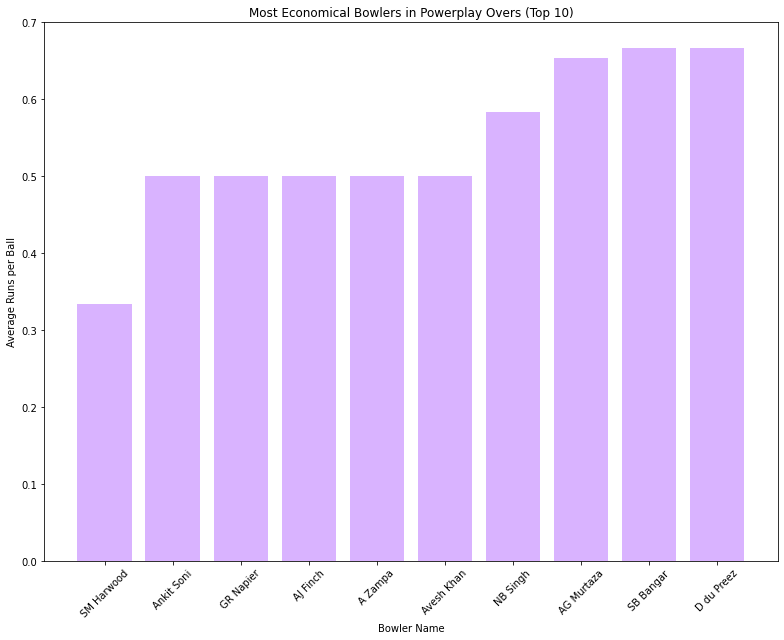

In [ ]:
# Assuming 'economical_bowlers_powerplay' is already executed and available as a Spark DataFrame
economical_bowlers_pd = economical_powerplay_bowler.toPandas()

# Visualizing using Matplotlib
plt.figure(figsize=(11, 9))
# Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.nsmallest(10, 'avg_runs_per_ball')

plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['avg_runs_per_ball'], color='#d9b3ff')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

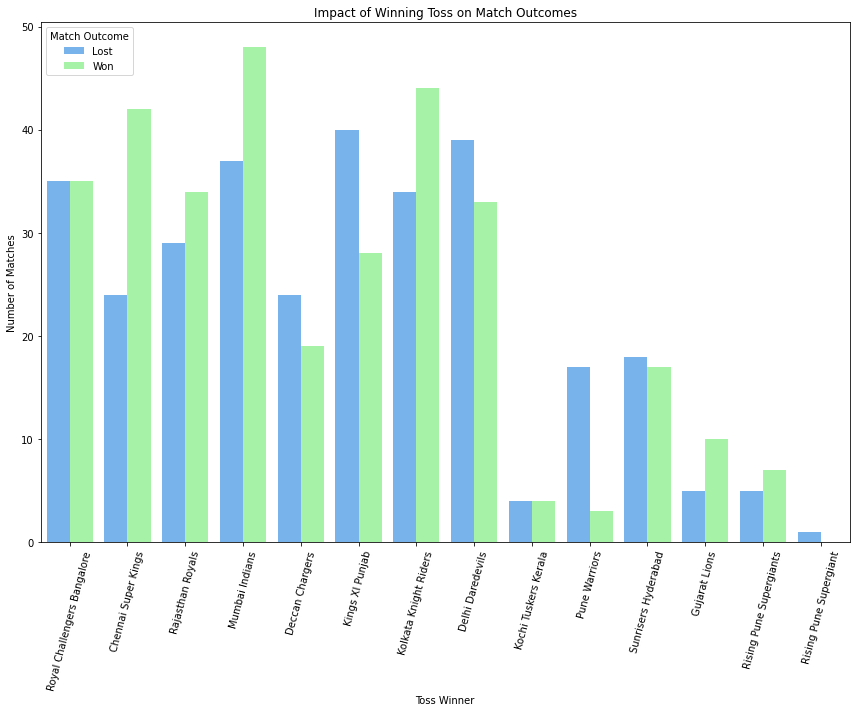

In [ ]:
# Create the plot with a custom color palette
plt.figure(figsize=(12, 10))

# Define a custom color palette
custom_palette = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']

sns.countplot(x='toss_winner', hue='toss_match_impact_outcomes', data=toss_impact_pd, palette=custom_palette)

plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


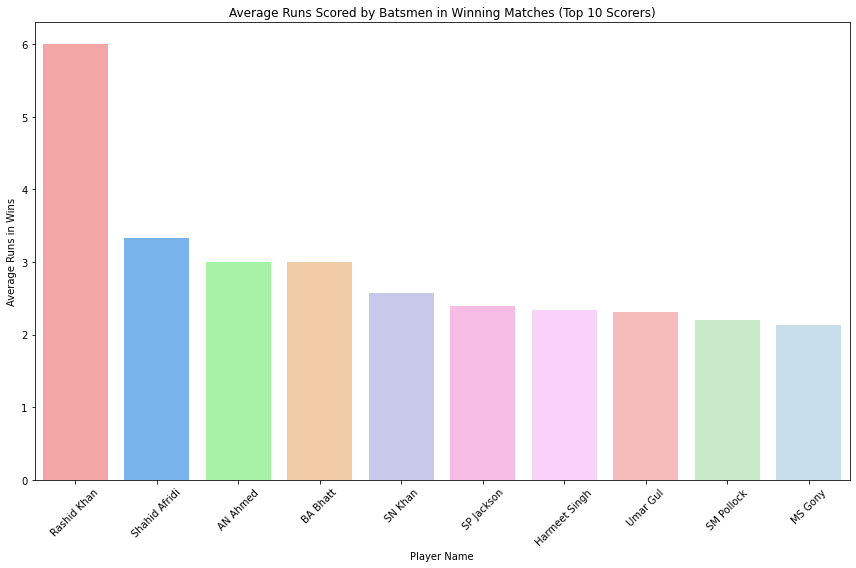

In [ ]:
average_runs_pd = average_runs_in_wins.toPandas()

# Using seaborn to plot average runs in winning matches
plt.figure(figsize=(12, 8))
top_scorers = average_runs_pd.nlargest(10, 'avg_runs_in_wins')
custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ffccff', '#ffb3b3', '#c2f0c2', '#c2e0f0']
sns.barplot(x='player_name', y='avg_runs_in_wins', data=top_scorers, palette=custom_colors)
plt.title('Average Runs Scored by Batsmen in Winning Matches (Top 10 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Average Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

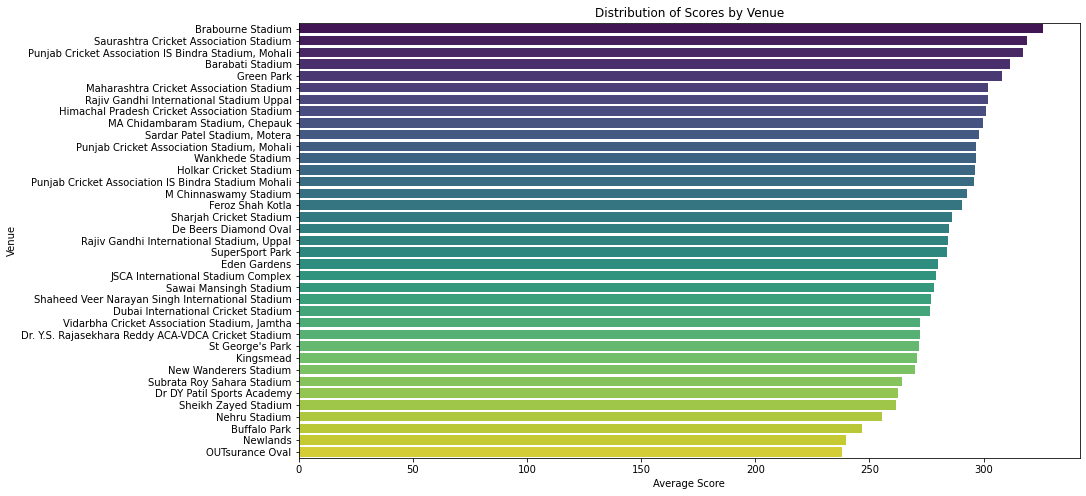

In [ ]:
# Convert to Pandas DataFrame
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='average_score', y='venue_name', data=scores_by_venue_pd,palette='viridis')
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()